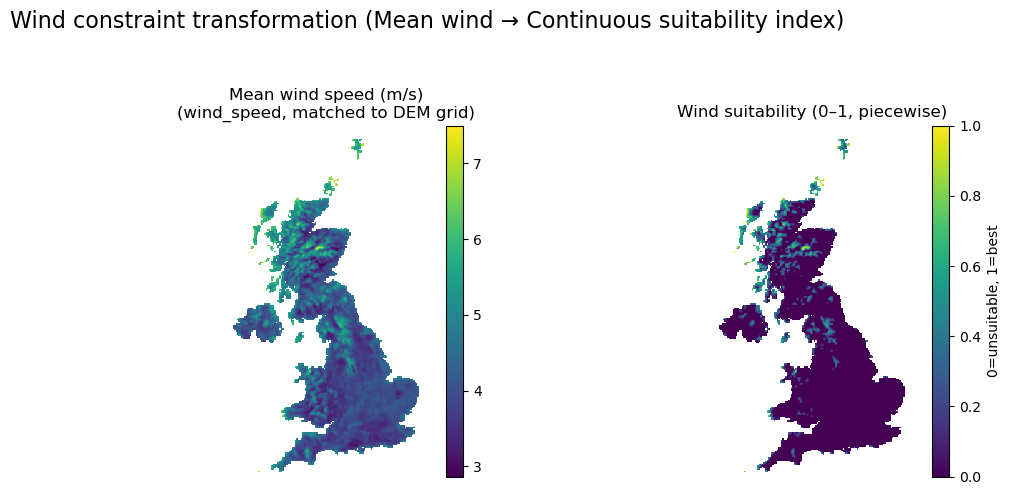


--- Wind suitability stats (matched to DEM grid) ---
Valid pixels: 41121
Mean suitability: 0.06501895934343338
Share in    <5.0:  85.83%  -> score 0.0
Share in 5.0–5.5:   8.14%  -> score 0.3
Share in 5.5–6.0:   4.01%  -> score 0.5
Share in 6.0–6.5:   1.53%  -> score 0.7
Share in 6.5–7.0:   0.40%  -> score 0.85
Share in    ≥7.0:   0.10%  -> score 1.0

Saved outputs to: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs
 - /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/wind_mean_nativegrid.tif
 - /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/wind_suitability_nativegrid.tif
 - /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/wind_mean_match_dem.tif
 - /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/wind_suitability_match_dem.tif
 - /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/figure_wind_constraint_continuous_piecewise.png


In [1]:
# ============================================================
# Wind constraint transformation (netCDF wind -> suitability 0-1)
# Using piecewise thresholds:
#   <5.0  -> 0
#   5.0-5.5 -> 0.3
#   5.5-6.0 -> 0.5
#   6.0-6.5 -> 0.7
#   6.5-7.0 -> 0.85
#   >=7.0 -> 1
# ============================================================

import os
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling
import xarray as xr
import matplotlib.pyplot as plt


DATA_DIR = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets"
DEM_PATH = os.path.join(DATA_DIR, "terrain.tif")
WIND_NC_PATH = os.path.join(DATA_DIR, "wind_speed.nc")

OUT_DIR = os.path.join(DATA_DIR, "outputs")
os.makedirs(OUT_DIR, exist_ok=True)


WIND_BINS   = [0.0, 5.0, 5.5, 6.0, 6.5, 7.0, np.inf]
WIND_SCORES = [0.0, 0.3, 0.5, 0.7, 0.85, 1.0]  # length = len(bins)-1



def write_geotiff(path, arr, profile, nodata=np.nan, dtype="float32"):
    prof = profile.copy()
    prof.update(
        driver="GTiff",
        dtype=dtype,
        count=1,
        compress="lzw",
        nodata=nodata
    )
    with rasterio.open(path, "w", **prof) as dst:
        dst.write(arr.astype(dtype), 1)


def netcdf_to_raster_mean(nc_path):
    """
    Load netCDF, pick first data variable, compute mean over 'time' or 'season' if present.
    Supports grids with coords:
      - lat/lon
      - x/y (projected)
    Returns: data2d, y_coords, x_coords, var_name, grid_type("latlon"|"xy")
    """
    ds = xr.open_dataset(nc_path)

    
    var_name = list(ds.data_vars.keys())[0]
    da = ds[var_name]

    for dim in ["time", "season"]:
        if dim in da.dims:
            da = da.mean(dim=dim, skipna=True)

    da = da.squeeze()

  
    coord_names = list(da.coords.keys())
    lat_name = lon_name = None
    x_name = y_name = None

    for c in coord_names:
        lc = c.lower()
        if "lat" in lc:
            lat_name = c
        if "lon" in lc:
            lon_name = c
        if lc == "x":
            x_name = c
        if lc == "y":
            y_name = c

    if lat_name is not None and lon_name is not None:
        da = da.transpose(lat_name, lon_name)
        lat = da[lat_name].values
        lon = da[lon_name].values
        data = da.values.astype("float32")
        return data, lat, lon, var_name, "latlon"

   
    if x_name is not None and y_name is not None:
        da = da.transpose(y_name, x_name)  # rows=y, cols=x
        y = da[y_name].values
        x = da[x_name].values
        data = da.values.astype("float32")
        return data, y, x, var_name, "xy"

    raise ValueError(f"Could not find lat/lon or x/y coords. Found coords={coord_names}")


def match_to_dem_grid(src_arr, src_transform, src_crs, dem_profile):
    """Reproject/resample src raster to DEM grid."""
    dst = np.full((dem_profile["height"], dem_profile["width"]), np.nan, dtype="float32")

    reproject(
        source=src_arr.astype("float32"),
        destination=dst,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dem_profile["transform"],
        dst_crs=dem_profile["crs"],
        resampling=Resampling.bilinear,
        src_nodata=np.nan,
        dst_nodata=np.nan
    )
    return dst


def wind_to_suitability_piecewise(wind, bins=WIND_BINS, scores=WIND_SCORES):
    """
    Convert wind speed (m/s) to suitability (0-1) using piecewise bins.
    Intervals: [bins[i], bins[i+1]) -> scores[i]
    """
    suit = np.full(wind.shape, np.nan, dtype="float32")
    valid = np.isfinite(wind)

    idx = np.digitize(wind[valid], bins, right=False) - 1
    idx = np.clip(idx, 0, len(scores) - 1)

    suit[valid] = np.array(scores, dtype="float32")[idx]
    return suit



with rasterio.open(DEM_PATH) as dem_src:
    dem_profile = dem_src.profile.copy()
    dem_crs = dem_src.crs


wind_data, y_or_lat, x_or_lon, wind_var, grid_type = netcdf_to_raster_mean(WIND_NC_PATH)
wind_mean_native = wind_data.astype("float32")


if grid_type == "latlon":
    lat = y_or_lat
    lon = x_or_lon

   
    if lat[0] < lat[-1]:
        wind_mean_native = np.flipud(wind_mean_native)
        lat = lat[::-1]

    wind_transform = from_bounds(
        float(lon.min()), float(lat.min()),
        float(lon.max()), float(lat.max()),
        len(lon), len(lat)
    )
    wind_src_crs = "EPSG:4326"

elif grid_type == "xy":
    y = y_or_lat
    x = x_or_lon

   
    if y[0] < y[-1]:
        wind_mean_native = np.flipud(wind_mean_native)
        y = y[::-1]

    wind_transform = from_bounds(
        float(x.min()), float(y.min()),
        float(x.max()), float(y.max()),
        len(x), len(y)
    )

    # Typical teaching datasets: wind grid CRS matches DEM CRS
    wind_src_crs = dem_profile["crs"]
else:
    raise RuntimeError("Unexpected grid type")


wind_suit_native = wind_to_suitability_piecewise(wind_mean_native)


WIND_MEAN_NATIVE_TIF = os.path.join(OUT_DIR, "wind_mean_nativegrid.tif")
WIND_SUIT_NATIVE_TIF = os.path.join(OUT_DIR, "wind_suitability_nativegrid.tif")

wind_profile_native = {
    "driver": "GTiff",
    "height": wind_mean_native.shape[0],
    "width": wind_mean_native.shape[1],
    "count": 1,
    "dtype": "float32",
    "crs": wind_src_crs,
    "transform": wind_transform,
    "nodata": np.nan
}

write_geotiff(WIND_MEAN_NATIVE_TIF, wind_mean_native, wind_profile_native, nodata=np.nan, dtype="float32")
write_geotiff(WIND_SUIT_NATIVE_TIF, wind_suit_native, wind_profile_native, nodata=np.nan, dtype="float32")


wind_mean_match = match_to_dem_grid(wind_mean_native, wind_transform, wind_src_crs, dem_profile)
wind_suit_match = match_to_dem_grid(wind_suit_native, wind_transform, wind_src_crs, dem_profile)

WIND_MEAN_MATCH_TIF = os.path.join(OUT_DIR, "wind_mean_match_dem.tif")
WIND_SUIT_MATCH_TIF = os.path.join(OUT_DIR, "wind_suitability_match_dem.tif")

write_geotiff(WIND_MEAN_MATCH_TIF, wind_mean_match, dem_profile, nodata=np.nan, dtype="float32")
write_geotiff(WIND_SUIT_MATCH_TIF, wind_suit_match, dem_profile, nodata=np.nan, dtype="float32")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Wind constraint transformation (Mean wind → Continuous suitability index)", fontsize=16)


im0 = axes[0].imshow(wind_mean_match, interpolation="nearest")
axes[0].set_title(f"Mean wind speed (m/s)\n({wind_var}, matched to DEM grid)")
axes[0].axis("off")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)


im1 = axes[1].imshow(wind_suit_match, vmin=0, vmax=1, interpolation="nearest")
axes[1].set_title("Wind suitability (0–1, piecewise)")
axes[1].axis("off")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label="0=unsuitable, 1=best")

plt.tight_layout(rect=[0, 0, 1, 0.93])
WIND_FIG = os.path.join(OUT_DIR, "figure_wind_constraint_continuous_piecewise.png")
plt.savefig(WIND_FIG, dpi=300)
plt.show()

valid = np.isfinite(wind_suit_match)
print("\n--- Wind suitability stats (matched to DEM grid) ---")
print("Valid pixels:", int(valid.sum()))
print("Mean suitability:", float(np.nanmean(wind_suit_match)))

labels = ["<5.0", "5.0–5.5", "5.5–6.0", "6.0–6.5", "6.5–7.0", "≥7.0"]
for i in range(len(WIND_SCORES)):
    lo = WIND_BINS[i]
    hi = WIND_BINS[i+1]
    if np.isinf(hi):
        m = valid & (wind_mean_match >= lo)
    else:
        m = valid & (wind_mean_match >= lo) & (wind_mean_match < hi)
    pct = m.sum() / valid.sum() * 100.0 if valid.sum() > 0 else np.nan
    print(f"Share in {labels[i]:>7}: {pct:6.2f}%  -> score {WIND_SCORES[i]}")

print("\nSaved outputs to:", OUT_DIR)
print(" -", WIND_MEAN_NATIVE_TIF)
print(" -", WIND_SUIT_NATIVE_TIF)
print(" -", WIND_MEAN_MATCH_TIF)
print(" -", WIND_SUIT_MATCH_TIF)
print(" -", WIND_FIG)